# Recommendation

1. 推薦系統的種類
    - collabrative(協同推薦)
    
    ![collabrative](./imgs/collabrative.jpg)
    
    - content-based(內容推薦)
    
    ![content-based](./imgs/content-based.jpg)


from [quora](https://www.quora.com/What-is-the-difference-between-content-based-filtering-and-collaborative-filtering)

## IMPORT & DATA

In [2]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

In [3]:
df_articles = pd.read_csv('shared_articles.csv')
df_articles = df_articles[df_articles['eventType'] == 'CONTENT SHARED']
df_articles.head(5)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
5,1459194522,CONTENT SHARED,-2826566343807132236,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


In [32]:
df_interactions = pd.read_csv('users_interactions.csv')
df_interactions.head(10)

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN
5,1465413742,VIEW,310515487419366995,-8763398617720485024,1395789369402380392,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,MG,BR
6,1465415950,VIEW,-8864073373672512525,3609194402293569455,1143207167886864524,NaN,NaN,NaN
7,1465415066,VIEW,-1492913151930215984,4254153380739593270,8743229464706506141,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
8,1465413762,VIEW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
9,1465413771,VIEW,3064370296170038610,3609194402293569455,1143207167886864524,NaN,NaN,NaN


## Preprocessing

In [33]:
set(df_interactions['eventType'])

{'BOOKMARK', 'COMMENT CREATED', 'FOLLOW', 'LIKE', 'VIEW'}

In [34]:
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5, 
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,  
}

# 請將eventType按照event_type_strength進行評分
#=============your works starts===============#
df_interactions['eventStrength'] = df_interactions['eventType'].apply(lambda x: event_type_strength[x])
#==============your works ends================#

print("平均互動分數:", np.average(df_interactions['eventStrength']))
# 平均互動分數: 1.2362885828078327

平均互動分數: 1.2362885828078327


在推薦系統中，有一個很常見的問題，稱為***cold-start***。因為，很多使用者並沒有真正的根產品產生任何互動，所以並沒有辦法從資料及當中了解到他們偏好。因此，這邊我們將少於五個interactions的user刪掉。

In [35]:
# 計算出每個使用者有對幾項不同的商品進行互動(hint: 以['personId', 'contentId']進行groupby取出現次數，再用'personId'進行groupby取出現次數)
# 篩選掉互動商品數小於五次的使用者(hint: return list)
#=============your works starts===============#
df_users_interactions_count = df_interactions.groupby(['personId', 'contentId']).size().groupby('personId').size()
users_with_enough_interactions = df_users_interactions_count[df_users_interactions_count >= 5].index.tolist()
#==============your works ends================#

print("平均對?個賞品有互動: ", np.average(df_users_interactions_count), "次")
print("使用者個數: ",  len(df_users_interactions_count))
print("互動大於5次使用者個數", len(users_with_enough_interactions))
# 平均互動次數:  21.482849604221634 次
# 使用者個數:  1895
# 互動大於5次使用者個數 1140

平均互動次數:  21.482849604221634 次
使用者個數:  1895
互動大於5次使用者個數 1140


In [36]:
# 找出df_interactions中personId在users_with_enough_interactions當中的row
#=============your works starts===============#
df_interactions_from_selected_users = df_interactions[df_interactions['personId'].apply(lambda x:x in set(users_with_enough_interactions))]
#==============your works ends================#

print('總互動比數:', len(df_interactions))
print('互動次數大於五用戶總互動比數:', len(df_interactions_from_selected_users))
# 總互動比數: 72312
# 互動次數大於五用戶總互動比數: 69868

總互動比數: 72312
互動次數大於五用戶總互動比數: 69868


In [37]:
def smooth_user_preference(x):
    # 請先+1再取log，以平滑互動分數
    #=============your works starts===============#
    logged = np.log(1+x)
    #==============your works ends================#
    return logged


print(smooth_user_preference(1))
print(smooth_user_preference(2))
print(smooth_user_preference(3))
# 0.6931471805599453
# 1.0986122886681098
# 1.3862943611198906

0.6931471805599453
1.0986122886681098
1.3862943611198906


In [38]:
# 計算使用者對於個別文章喜愛的加總
# 並透過上面的smooth_user_preference使其平滑
#=============your works starts===============#
df_interactions_full_no_smooth = df_interactions_from_selected_users.groupby(['personId', 'contentId'])['eventStrength'].sum()
df_interactions_full = df_interactions_full_no_smooth.apply(smooth_user_preference).reset_index()
#==============your works ends================#

print('平均喜好分數(未平滑)', np.average(df_interactions_full_no_smooth))
print('平均喜好分數(平滑)', np.average(df_interactions_full))
# 平均喜好分數(未平滑) 2.214954226972843
# 平均喜好分數(平滑) 1.015265936675581

平均喜好分數(未平滑) 2.214954226972843
平均喜好分數(平滑) -2.7931391804641068e+16


## 評價
### 基礎知識

|     col    | Retrieved         | Non Retrieved      |
|------------|-------------------|--------------------|
| Relevant   | True Positive(TP) | False Negative(TN) |
| Irrelevant | False Postive(FP) | True Negative(TN)  |

### 解釋
1. Precision at K

$$ Precision={|Relevant \cap Retrieved| \over |Retrieved|}={|TP| \over |TP|+|FP|}\quad \quad$$

2. Recall at K

$$ Recall={|Relevant \cap Retrieved| \over |Relevant|}={|TP| \over |TP|+|FN|}\quad \quad$$

3. F measure

    1. 算術平均數

    $$F={P+R \over 2}\quad where \quad P=Precision,\; R=Recall \quad \quad$$

    2. 幾何平均數

    $$F =\cfrac{1}{\alpha  {\cfrac{1}{P}} + (1 - \alpha )  {\cfrac{1}{R}}}= \cfrac{(\beta ^2 +1)PR}{\beta ^2 B +R} \quad where \quad \beta ^2 = \cfrac{1- \alpha}{\alpha}\quad \quad$$
    
    3. $F_\beta$ or $F_1$
    
    $$ F_1 = F_\beta = \cfrac{1}{0.5  {\cfrac{1}{P}} + 0.5 {\cfrac{1}{R}}} = \cfrac{PR}{0.5P+0.5R} = \cfrac{2PR}{P+R}$$

4. R-Precision
5. NDCG
6. MAP

### 注意事項
1. 注意與Accuracy的區別
$$ {|TP|+|TF| \over |TP|+|TN|+|FP|+|FN|} \quad \quad$$

2. [參考資訊](https://goatwang.github.io/2017/04/22/Evaluation-in-Information-Retrieval/)


In [39]:
# ground truth
# 找出每一個personId曾經互動過「不重複」的文章
#=============your works starts===============#
df_answer = df_interactions_full.groupby(['personId'])['contentId'].apply(set).reset_index()
#==============your works ends================#

df_answer.head(5)
# personId	contentId
# 0	-9223121837663643404	{5211673327552264703, -5002383425685129595, -7...
# 1	-9212075797126931087	{-1995591062742965408, 6852597772196653540, -9...
# 2	-9207251133131336884	{-4029704725707465084, -1297580205670251233, -...
# 3	-9199575329909162940	{5293701842202310496, -5002383425685129595, 54...
# 4	-9196668942822132778	{-721732705314803549, -8813724423497152538, -8...

,personId,contentId
0,-9223121837663643404,"{5211673327552264703, -5002383425685129595, -7..."
1,-9212075797126931087,"{-1995591062742965408, 6852597772196653540, -9..."
2,-9207251133131336884,"{-4029704725707465084, -1297580205670251233, -..."
3,-9199575329909162940,"{5293701842202310496, -5002383425685129595, 54..."
4,-9196668942822132778,"{-721732705314803549, -8813724423497152538, -8..."


## Popularity model (Base Line)

In [40]:
# 以contentId進行groupby，按照每篇文章總分數進行排序
#=============your works starts===============#
df_item_popularity = df_interactions_full.groupby('contentId')['eventStrength'].sum().sort_values(ascending=False).reset_index()
#==============your works ends================#

df_item_popularity.head(5).to_dict(orient='record')
# [{'contentId': -4.029704725707465e+18, 'eventStrength': 213.30481497288199},
#  {'contentId': -6.783772548752092e+18, 'eventStrength': 162.03158006500846},
#  {'contentId': -1.3313934239753886e+17, 'eventStrength': 158.05458586966674},
#  {'contentId': -8.208801367848628e+18, 'eventStrength': 136.62458307425328},
#  {'contentId': -6.843047699859122e+18, 'eventStrength': 134.34939619163308}]

[{'contentId': -4.029704725707465e+18, 'eventStrength': 213.30481497288199},
 {'contentId': -6.783772548752092e+18, 'eventStrength': 162.03158006500846},
 {'contentId': -1.3313934239753886e+17, 'eventStrength': 158.05458586966674},
 {'contentId': -8.208801367848628e+18, 'eventStrength': 136.62458307425328},
 {'contentId': -6.843047699859122e+18, 'eventStrength': 134.34939619163308}]

In [42]:
def popularity_recommend(user_id):
    # 直接回傳分數加總最高的500篇文章
    #=============your works starts===============#
    recommend = df_item_popularity.loc[:500, 'contentId'].values    
    #==============your works ends================#
    return recommend

# 透過apply function使用popularity_recommend到df_interactions_full["personId"]的每一個row上
df_answer['popularity_recommend'] = df_answer["personId"].apply(popularity_recommend)
df_answer.head(5)

,personId,contentId,popularity_recommend
0,-9223121837663643404,"{5211673327552264703, -5002383425685129595, -7...","[-4029704725707465084, -6783772548752091658, -..."
1,-9212075797126931087,"{-1995591062742965408, 6852597772196653540, -9...","[-4029704725707465084, -6783772548752091658, -..."
2,-9207251133131336884,"{-4029704725707465084, -1297580205670251233, -...","[-4029704725707465084, -6783772548752091658, -..."
3,-9199575329909162940,"{5293701842202310496, -5002383425685129595, 54...","[-4029704725707465084, -6783772548752091658, -..."
4,-9196668942822132778,"{-721732705314803549, -8813724423497152538, -8...","[-4029704725707465084, -6783772548752091658, -..."


In [43]:
def precision_at_k(row, k=10):
    # 計算每一個row的precision_at_k
    #=============your works starts===============#
    precision = len(set(row['popularity_recommend'][:k]) & set(row['contentId'])) / k
    #==============your works ends================#
    return precision

evaluation_result = df_answer.apply(precision_at_k, axis=1)
print("Average Precision At K:", np.average(evaluation_result))
# Average Precision At K: 0.08511873350923484

Average Precision At K: 0.08511873350923484


In [44]:
def recall_at_k(row, k=10):
    # 計算每一個row的recall_at_k
    #=============your works starts===============#
    recall = len(set(row['popularity_recommend'][:k]) & set(row['contentId'])) / len(row['contentId'])
    #==============your works ends================#
    return recall

evaluation_result = df_answer.apply(recall_at_k, axis=1)
print("Average Recall At K:", np.average(evaluation_result))
# Average Recall At K: 0.08730221807976521

Average Recall At K: 0.08730221807976521


In [15]:
precisions_popularity = []
recalls_popularity = []
for k in range(1, 500):
    # 找出k個retrieved結果下的precision並append到precisions中
    # 找出k個retrieved結果下的recall並append到recalls中
    #=============your works starts===============#
    p_avg = np.average(df_answer.apply(precision_at_k, axis=1, k=k))
    r_avg = np.average(df_answer.apply(recall_at_k, axis=1, k=k))
    precisions_popularity.append(p_avg)
    recalls_popularity.append(r_avg)
    #==============your works ends================#

print(precisions_popularity[:5])
print(recalls_popularity[:5])
# [0.14142480211081795, 0.12163588390501319, 0.1150395778364116, 0.1054089709762533, 0.09931398416886543]
# [0.023556124542213237, 0.034394715562071, 0.043386947980631974, 0.04921683202394738, 0.05832411771369351]

[0.14142480211081795, 0.12163588390501319, 0.1150395778364116, 0.1054089709762533, 0.09931398416886543]
[0.023556124542213237, 0.034394715562071, 0.043386947980631974, 0.04921683202394738, 0.05832411771369351]


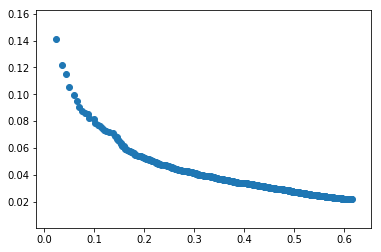

In [16]:
plt.scatter(recalls_popularity, precisions_popularity)
plt.show()

## Content-Based Filtering model

In [17]:
stopwords_list = stopwords.words('english') + stopwords.words('portuguese')
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0.003, max_df=0.5, max_features=5000, stop_words=stopwords_list)


In [46]:
# 計算df_articles['title'] + " " + df_articles['text']中每個row的tfidf_matrix
#=============your works starts===============#
tfidf_matrix = vectorizer.fit_transform(df_articles['title'] + " " + df_articles['text'])
#==============your works ends================#

np.sum(tfidf_matrix[:5].toarray(), axis=1)
# array([ 9.50111727,  8.76829702,  7.07315723, 10.39925989,  7.69531653])

array([ 9.50111727,  8.76829702,  7.07315723, 10.39925989,  7.69531653])

In [47]:
# article id
item_ids = df_articles['contentId'].tolist()
item_ids_set = set(item_ids)

def get_user_vector(like_content_list):
    # 找出like_content_list中每一篇文章所在的位置idx
    #=============your works starts===============#
    idxs = [item_ids.index(i) for i in like_content_list if i in item_ids_set]
    #==============your works ends================#
    if len(idxs) == 0:
        # 初始劃一條全部為零，與tfidf_matrix中每一條向量等長的np.array()
        #=============your works starts===============#
        average_vector = np.zeros(tfidf_matrix.shape[1])
        #==============your works ends================#
    else:
        # 使用idxs找出tfidf_matrix中的對應向量
        # 並element-wise的計算每一條向量中每個元素的平均值(axis=0)
        #=============your works starts===============#
        tfidf_vectors = tfidf_matrix[idxs].toarray()
        average_vector = np.average(tfidf_vectors, axis=0)
        #==============your works ends================#
    return average_vector

df_answer['preference_vector'] = df_answer['contentId'].apply(get_user_vector)
df_answer['preference_vector'].head(5)
# 0    [0.002215745405614616, 0.0030089016793024893, ...
# 1    [0.0, 0.012489418801235969, 0.0, 0.0, 0.003228...
# 2    [0.013707054489011659, 0.0020078374794908756, ...
# 3    [0.0, 0.006133107865163184, 0.0, 0.0, 0.003888...
# 4    [0.0, 0.0, 0.0, 0.0, 0.018891626761135934, 0.0...
# Name: preference_vector, dtype: object

0    [0.002215745405614616, 0.0030089016793024893, ...
1    [0.0, 0.012489418801235969, 0.0, 0.0, 0.003228...
2    [0.013707054489011659, 0.0020078374794908756, ...
3    [0.0, 0.006133107865163184, 0.0, 0.0, 0.003888...
4    [0.0, 0.0, 0.0, 0.0, 0.018891626761135934, 0.0...
Name: preference_vector, dtype: object

In [48]:
# 使用cosine_similarity去計算每一個preference_vector與每一篇待選文章的cosine similarity
#=============your works starts===============#
user_preference_vectors = np.hstack(df_answer['preference_vector'].values).reshape(-1, len(df_answer['preference_vector'].iloc[0]))
similarity_metric = cosine_similarity(user_preference_vectors, tfidf_matrix)
#==============your works ends================#
#請特別注意:
# 每一個row是使用者對每一篇文章的similarity(preference)
# 所以接下來要篩出，每一個row當中similarity最高分的10篇文章

print(similarity_metric.shape)
# (1895, 3047)
similarity_metric[:5, :5]
# array([[0.11906298, 0.10576356, 0.23490161, 0.16308151, 0.14992823],
#        [0.03358471, 0.03448321, 0.13672524, 0.04660727, 0.04195372],
#        [0.04197812, 0.03863454, 0.04912078, 0.08057892, 0.02526139],
#        [0.08572221, 0.0880551 , 0.10085452, 0.13203768, 0.08862588],
#        [0.0424938 , 0.01100553, 0.01393111, 0.0539832 , 0.04202164]])

(1895, 3047)


array([[0.11906298, 0.10576356, 0.23490161, 0.16308151, 0.14992823],
       [0.03358471, 0.03448321, 0.13672524, 0.04660727, 0.04195372],
       [0.04197812, 0.03863454, 0.04912078, 0.08057892, 0.02526139],
       [0.08572221, 0.0880551 , 0.10085452, 0.13203768, 0.08862588],
       [0.0424938 , 0.01100553, 0.01393111, 0.0539832 , 0.04202164]])

In [50]:
# 使用np.argsort將每一個row的similarity進行排序，然後倒過來排續，篩出前500個
#=============your works starts===============#
top_content_idxs = np.argsort(similarity_metric, axis=1)[:, ::-1][:, :500]
#==============your works ends================#
# 請注意這邊的產出代表的是每一篇文章的在tfidf_matrix的idx位置
# 必須與contentId區別

top_content_idxs
# array([[ 650, 1032, 1643, ...,  237, 1034, 3018],
#        [ 977, 1023, 1601, ..., 1548, 1175, 1769],
#        [1671, 1593, 1795, ..., 2477, 1117, 1520],
#        ...,
#        [1622, 1845, 3021, ...,  974, 1035, 1607],
#        [1185, 1636, 1116, ..., 2309, 2357, 2616],
#        [2664, 2781,  659, ..., 2634, 1552, 3018]], dtype=int64)

array([[ 650, 1032, 1643, ..., 2179, 2547,  985],
       [ 977, 1023, 1601, ..., 1544, 1671,  394],
       [1671, 1593, 1795, ..., 1733, 2880, 2467],
       ...,
       [1622, 1845, 3021, ..., 2519, 2148,  126],
       [1185, 1636, 1116, ..., 1355, 1610,  826],
       [2664, 2781,  659, ...,  597,  909,  300]], dtype=int64)

In [51]:
# 將tfidf_matrix的idx轉換成contentId
#=============your works starts===============#
top_contentId = np.array([np.array(item_ids)[top_content_idx] for top_content_idx in top_content_idxs])
#==============your works ends================#

top_contentId[:5, :3]
# array([[ 8596997246990922861,  2858969450431709251, -4541461982704074404],
#        [-1995591062742965408,  6852597772196653540,  -969155230116728853],
#        [-1297580205670251233, -9216926795620865886, -4434534460030275781],
#        [-1755875383603052680,  5293701842202310496,  5037403311832115000],
#        [ 9175693555063886126,  7013665235990336340, -2069509552243850466]],
#       dtype=int64)

array([[ 8596997246990922861,  2858969450431709251, -4541461982704074404],
       [-1995591062742965408,  6852597772196653540,  -969155230116728853],
       [-1297580205670251233, -9216926795620865886, -4434534460030275781],
       [-1755875383603052680,  5293701842202310496,  5037403311832115000],
       [ 9175693555063886126,  7013665235990336340, -2069509552243850466]],
      dtype=int64)

In [52]:
# 將top_10_contentId指派回df_answer['content_based_recommended']
#=============your works starts===============#
df_answer['content_based_recommended'] = list(top_contentId)
#==============your works ends================#


In [53]:
def precision_at_k(row, k=10):
    # 計算每一個row的precision_at_k
    #=============your works starts===============#
    precision = len(set(row['content_based_recommended'][:k]) & set(row['contentId'])) / k
    #==============your works ends================#
    return precision

evaluation_result = df_answer.apply(precision_at_k, axis=1)
print("Average Precision At K:", np.average(evaluation_result))
# Average Precision At K: 0.4271240105540897

Average Precision At K: 0.4271240105540897


In [25]:
def recall_at_k(row, k=10):
    # 計算每一個row的recall_at_k
    #=============your works starts===============#
    precision = len(set(row['content_based_recommended'][:k]) & set(row['contentId'])) / len(row['contentId'])
    #==============your works ends================#
    return precision

evaluation_result = df_answer.apply(recall_at_k, axis=1)
print("Average Recall At K:", np.average(evaluation_result))
# Average Recall At K: 0.7014372644445073

Average Recall At K: 0.7014372644445073


In [26]:
precisions_content_based = []
recalls_content_based = []
for k in range(1, 500):
    # 找出k個retrieved結果下的precision並append到precisions中
    # 找出k個retrieved結果下的recall並append到recalls中
    #=============your works starts===============#
    p_avg = np.average(df_answer.apply(precision_at_k, axis=1, k=k))
    r_avg = np.average(df_answer.apply(recall_at_k, axis=1, k=k))
    precisions_content_based.append(p_avg)
    recalls_content_based.append(r_avg)
    #==============your works ends================#

print(precisions_content_based[:5])
print(recalls_content_based[:5])
# [0.8881266490765172, 0.8007915567282322, 0.7261213720316623, 0.662269129287599, 0.6073878627968338]
# [0.2902330255447432, 0.4325134024349371, 0.5155799081444566, 0.5702582888232454, 0.609574135903257]

[0.8881266490765172, 0.8007915567282322, 0.7261213720316623, 0.662269129287599, 0.6073878627968338]
[0.2902330255447432, 0.4325134024349371, 0.5155799081444566, 0.5702582888232454, 0.609574135903257]


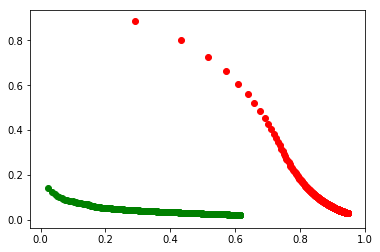

In [27]:
plt.scatter(recalls_popularity, precisions_popularity, c='g')
plt.scatter(recalls_content_based, precisions_content_based, c='r')
plt.show()